# Course Project: Galaxy Classifier

### Lexy Andershock, Gian Fernandez-Aleman, David Long

#### Introduction
This course project for our Intro to Machine Learning course (COSC325) utilizes a Stochastic Gradient Descent model, a Random Forest Generator model and a K-Nearest Neighbor model on a dataset of colored galaxy images (Galaxy10 SDSS). While the dataset was originally used with a CNN (a more appropriate model for image data), we wanted to experiment and see what we could do with it using a few of the learning techniques we've learned in class.

#### Who is this for?
Our target audience for this project would include astronomers, physicists, space enthusiasts, space researchers, educators, and general populations with an interest in galaxy-shape indentification.

#### Purpose of the Project
The problem we are trying to solve is identifying the shapes of newly discovered galaxies. This dataset contains 10 unique categories of different-shaped galaxies, and we want to train models to be able to assign one of these categories to new images of galaxies it hasn't encountered yet. With new space telescopes such as JWST, we are discovering new galaxies at an accelerating rate, and being able to quickly classify them for studying would be very useful instead of manually doing it. This would make users' lives significantly better as they can have a system that handles massive amounts of galaxy photosets and produces accurate results, which is more time-efficient as opposed to manually determining the galaxy shapes.

### 1. Setting Up The Environment
We must ensure that we have imported all the appropriate libraries that we will utilize for our data manipulation and modeling.

In [26]:
# Import required libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import requests
import os

# Scikit-learn libraries and routines
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

### 2. Downloading and Extracting Data + Showing Some Galaxies From Each Label
We then download and extract our data from the dataset and organize them into two separate categories: images and labels. One image from each galaxy label is shown for reference

File already downloaded.


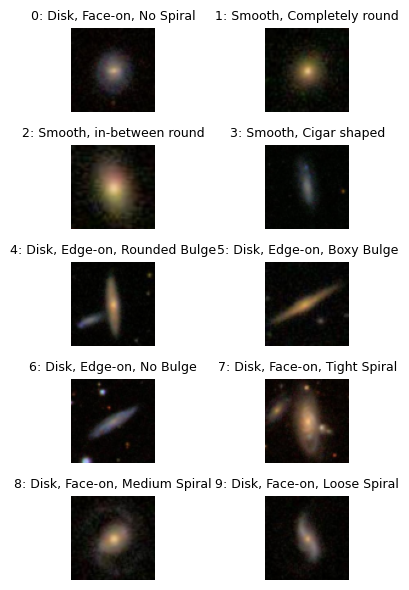

In [27]:
# Document how to download + import the dataset
url = "https://zenodo.org/records/10844811/files/Galaxy10.h5"
file_name = "Galaxy10.h5"

response = requests.get(url, stream=True)
if os.path.exists("Galaxy10.h5"):
    print("File already downloaded.")
else:
    with open(file_name, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete!")

# To get the images and labels from file
with h5py.File(file_name, 'r') as data:
    images = np.array(data['images'])
    labels = np.array(data['ans'])

label_names = [
        "Disk, Face-on, No Spiral",
        "Smooth, Completely round",
        "Smooth, in-between round",
        "Smooth, Cigar shaped",
        "Disk, Edge-on, Rounded Bulge",
        "Disk, Edge-on, Boxy Bulge",
        "Disk, Edge-on, No Bulge",
        "Disk, Face-on, Tight Spiral",
        "Disk, Face-on, Medium Spiral",
        "Disk, Face-on, Loose Spiral"
    ]        

# Find one sample per unique label
unique_classes = np.unique(labels)
class_examples = []

for class_id in unique_classes:
    idx = np.where(labels == class_id)[0][0]
    class_examples.append((images[idx], class_id))

# Plot in 5 rows of 2
fig, axes = plt.subplots(5, 2, figsize=(5, 6))
axes = axes.flatten()

for i, (img, label) in enumerate(class_examples):
    axes[i].imshow(img)
    axes[i].set_title(f"{label}: {label_names[label]}", fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### 3. Processing Data
We then process our data. In this case, we'll flatten the color images and normalize the pixel values

In [28]:
# Flatten images
n_samples, height, width, channels = images.shape
X = images.reshape(n_samples, height * width * channels)
y = labels

# Normalize pixel values between 0 and 1
X = X.astype(np.float32) / 255.0

### 4. Splitting Data
Once we have the data put into separate categories, we split it into training and testing categories.

In [29]:
# Shuffle the full dataset before splitting
X, y = shuffle(X, y, random_state = 42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, stratify = y, random_state = 42)

### 5. Scaling Features
We'll scale the features

In [30]:
# Create and fit the scaler on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA after scaling
pca = PCA(n_components = 1500)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### 6. Training The Model!
We'll start training the Stochastic Gradient Descent regression model

In [31]:
# Train the model using Stochastic Gradient Descent
model = OneVsRestClassifier(SGDClassifier(loss = 'log_loss', max_iter = 5000))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(loss='log_loss', max_iter=5000))

### 7. Predicting Using The Model
We'll predict on the test set using the model we just trained

Model Accuracy : 0.34

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.41      0.27       346
           1       0.38      0.32      0.35       700
           2       0.43      0.39      0.41       629
           3       0.10      0.06      0.07        35
           4       0.58      0.43      0.50       153
           5       0.00      0.00      0.00         2
           6       0.57      0.46      0.51        59
           7       0.35      0.17      0.23       112
           8       0.30      0.14      0.19        91
           9       0.13      0.08      0.10        52

    accuracy                           0.34      2179
   macro avg       0.30      0.25      0.26      2179
weighted avg       0.37      0.34      0.35      2179



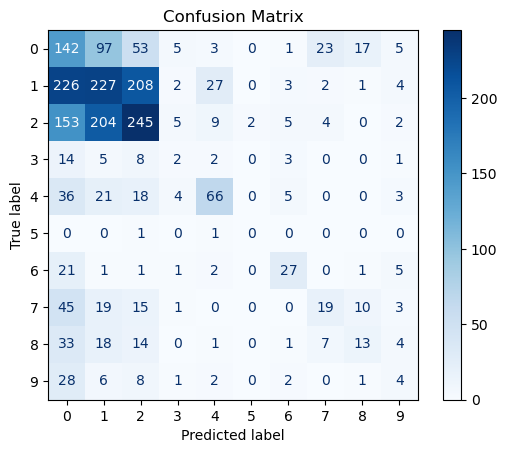

In [32]:
# Predict on the test set
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy : {accuracy:.2f}\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division = 0))

cm_test = confusion_matrix(y_test, y_pred, normalize='true')

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 8. Model #2: Random Forest
For our second model, we decided to use a random forest.

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.46      0.45       346
           1       0.77      0.96      0.85       700
           2       0.76      0.76      0.76       629
           3       0.43      0.09      0.14        35
           4       0.72      0.77      0.74       153
           5       0.00      0.00      0.00         2
           6       0.69      0.78      0.73        59
           7       0.51      0.28      0.36       112
           8       0.33      0.02      0.04        91
           9       0.50      0.02      0.04        52

    accuracy                           0.69      2179
   macro avg       0.51      0.41      0.41      2179
weighted avg       0.66      0.69      0.66      2179

Confusion Matrix:


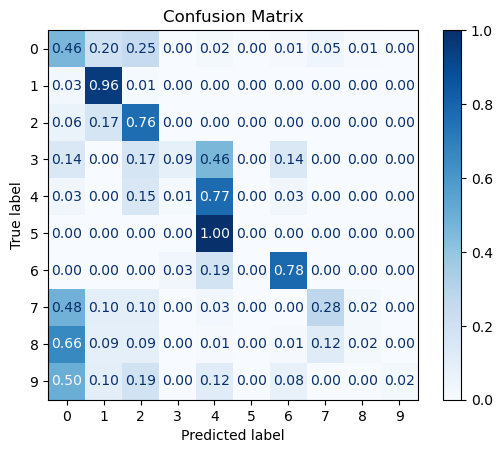

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y, random_state=42)

# Apply standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=rf_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()

### 9. Model #3: K-Nearest Neighbors
For our third model, we decided to use K-Nearest Neighbors.

KNN Model Accuracy: 0.58

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.32      0.35       346
           1       0.62      0.90      0.73       700
           2       0.65      0.62      0.64       629
           3       0.19      0.14      0.16        35
           4       0.70      0.57      0.63       153
           5       0.00      0.00      0.00         2
           6       0.60      0.47      0.53        59
           7       0.29      0.15      0.20       112
           8       0.29      0.02      0.04        91
           9       1.00      0.02      0.04        52

    accuracy                           0.58      2179
   macro avg       0.47      0.32      0.33      2179
weighted avg       0.57      0.58      0.55      2179

Confusion Matrix:


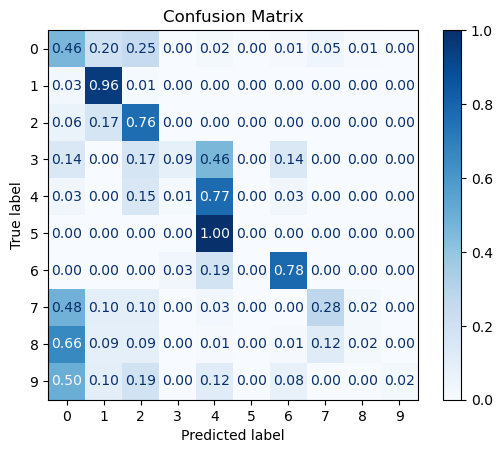

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 5)

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"KNN Model Accuracy: {accuracy_knn:.2f}\n")

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_knn, zero_division = 0))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=knn_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()